In [23]:
import pandas as pd

df = pd.read_csv("Dataset/task2/train.csv")

### Drop some that not make sense

In [24]:
df.drop(columns = ["player_id", "random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

In [25]:
num_cols = df.select_dtypes(include = ["float"]).columns
num_cols.size

31

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Found unique target values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


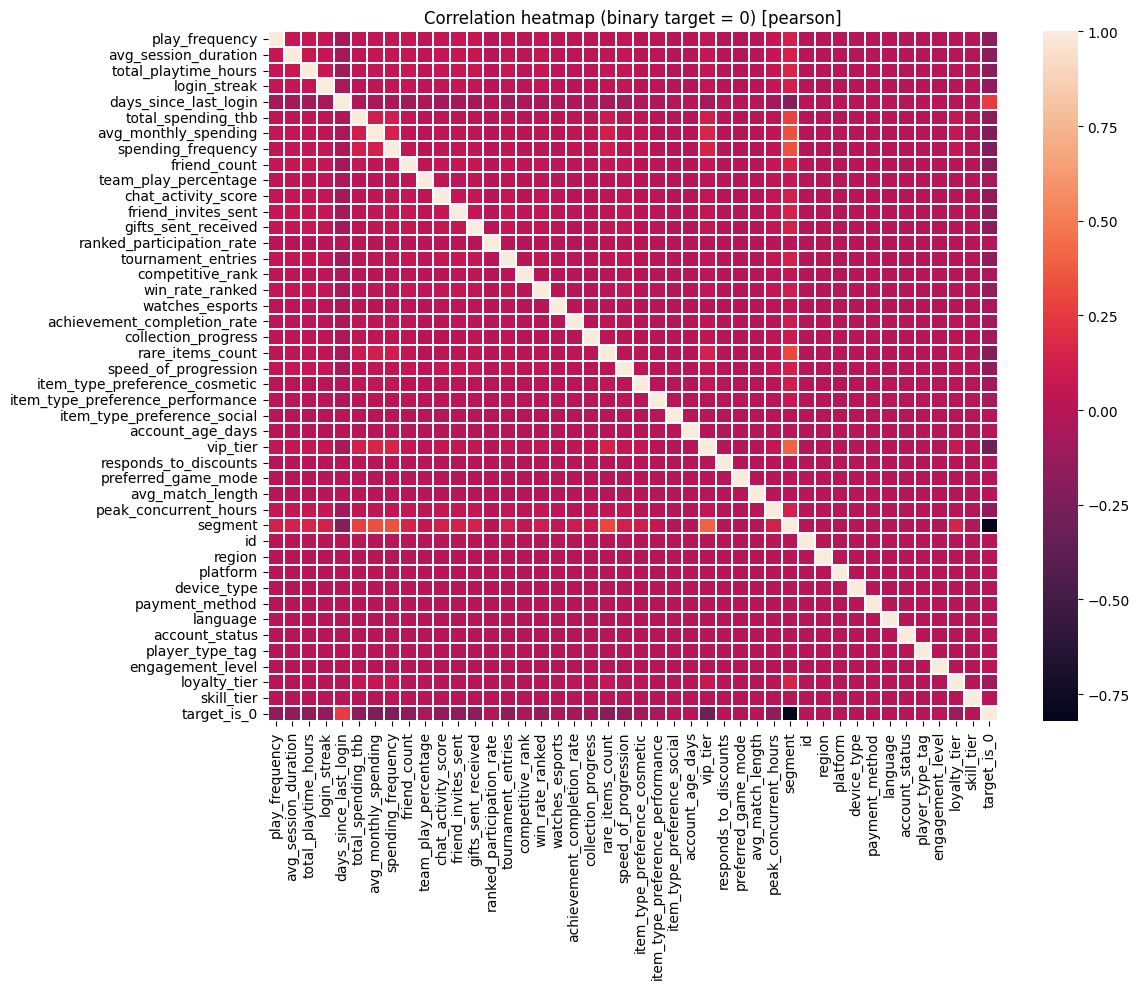


Top features correlated with target == 0:
segment                  0.822063
vip_tier                 0.295859
days_since_last_login    0.252807
avg_monthly_spending     0.235571
spending_frequency       0.235116
rare_items_count         0.207281
total_playtime_hours     0.195110
friend_count             0.183759
total_spending_thb       0.183158
gifts_sent_received      0.175868
avg_session_duration     0.170438
friend_invites_sent      0.169157
peak_concurrent_hours    0.162986
play_frequency           0.161116
speed_of_progression     0.158418
login_streak             0.156270
tournament_entries       0.155638
chat_activity_score      0.153209
win_rate_ranked          0.140331
loyalty_tier             0.104763
Name: target_is_0, dtype: float64


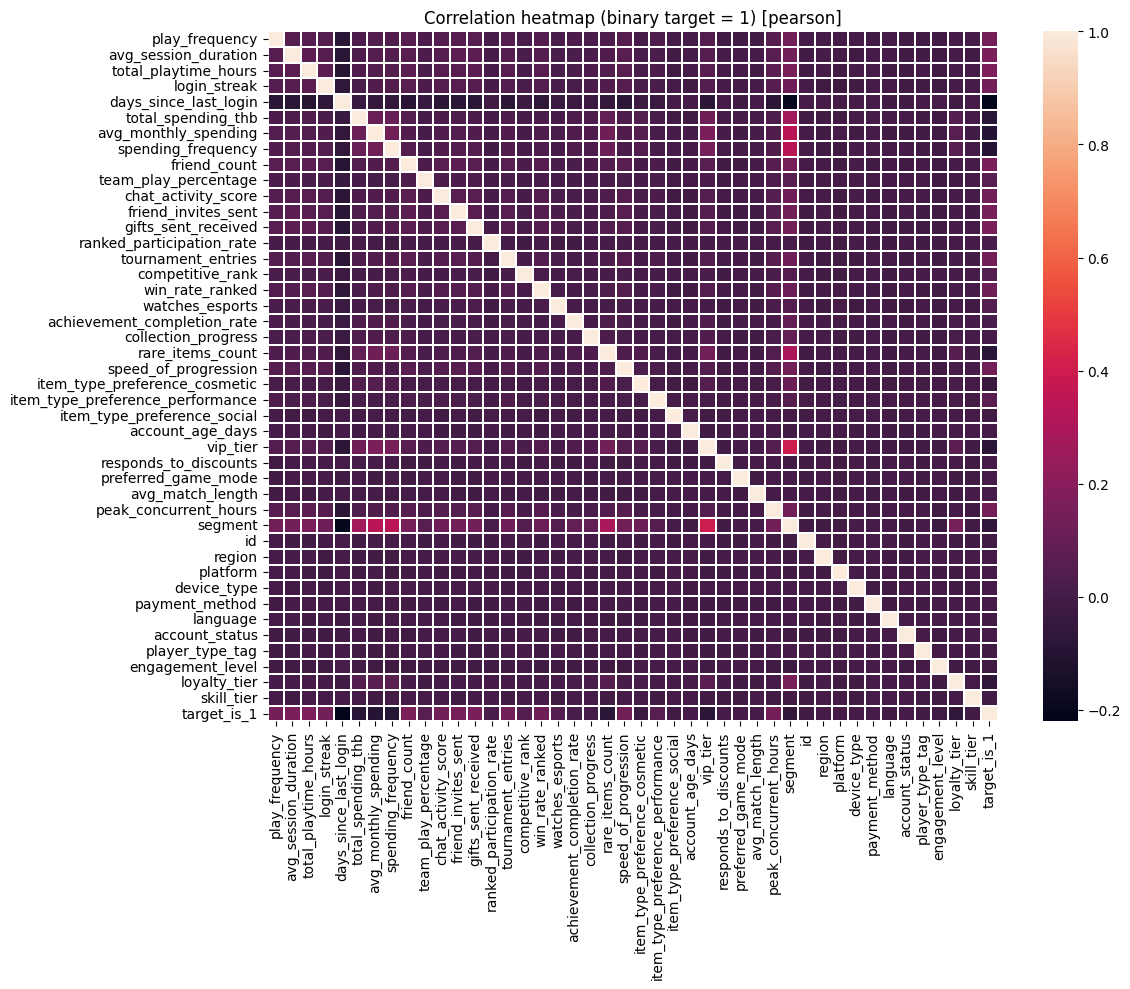


Top features correlated with target == 1:
days_since_last_login    0.220216
total_playtime_hours     0.170486
friend_count             0.161494
gifts_sent_received      0.159868
avg_session_duration     0.157262
friend_invites_sent      0.150678
peak_concurrent_hours    0.146595
play_frequency           0.143447
tournament_entries       0.137595
login_streak             0.137373
speed_of_progression     0.137144
chat_activity_score      0.133424
win_rate_ranked          0.122519
avg_monthly_spending     0.098557
spending_frequency       0.097950
rare_items_count         0.083684
total_spending_thb       0.082941
vip_tier                 0.081240
loyalty_tier             0.064336
team_play_percentage     0.063924
Name: target_is_1, dtype: float64


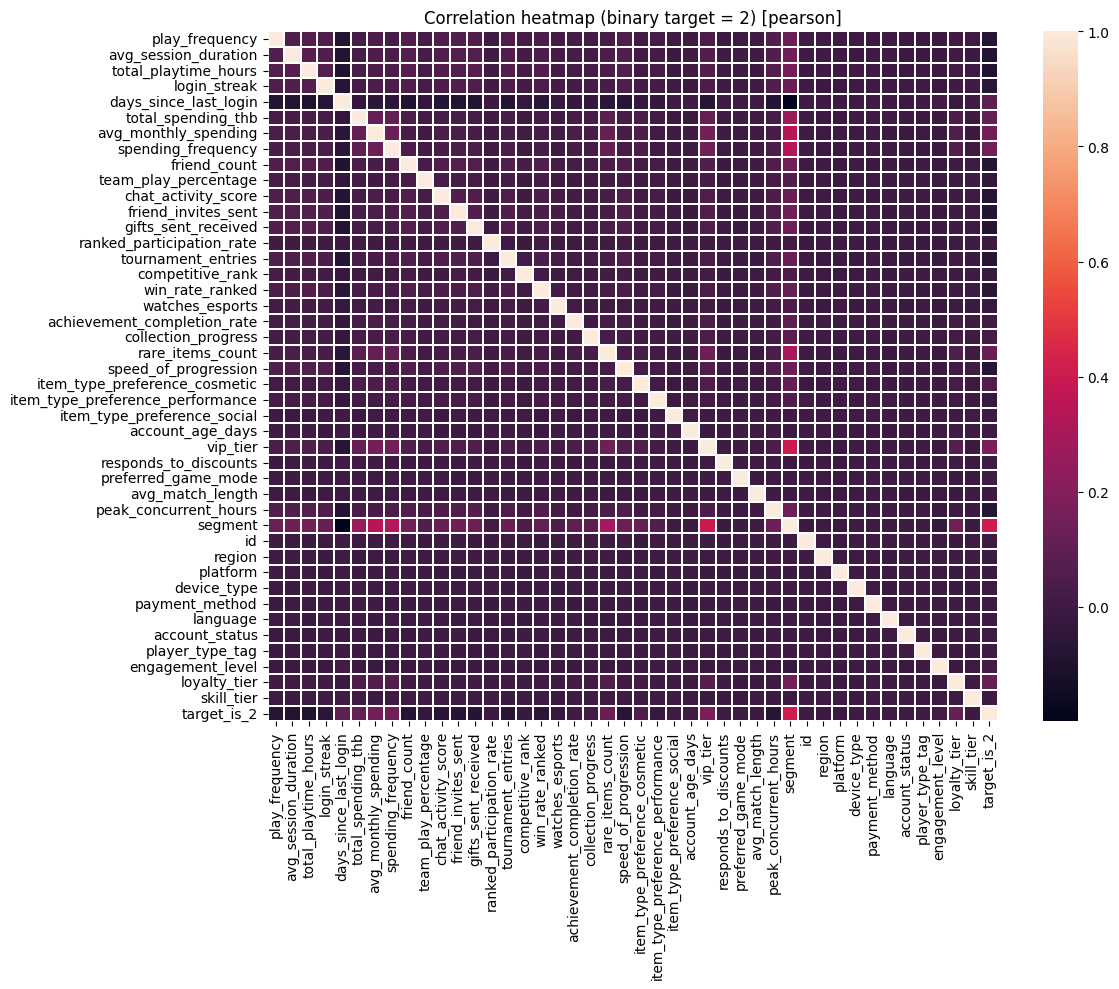


Top features correlated with target == 2:
segment                  0.406485
vip_tier                 0.171112
avg_monthly_spending     0.150980
spending_frequency       0.147304
rare_items_count         0.124485
total_spending_thb       0.114461
loyalty_tier             0.112098
days_since_last_login    0.094902
total_playtime_hours     0.087466
avg_session_duration     0.085273
friend_count             0.081376
friend_invites_sent      0.080702
gifts_sent_received      0.078271
play_frequency           0.073654
peak_concurrent_hours    0.073375
tournament_entries       0.072215
speed_of_progression     0.070835
chat_activity_score      0.070174
login_streak             0.067231
win_rate_ranked          0.061956
Name: target_is_2, dtype: float64


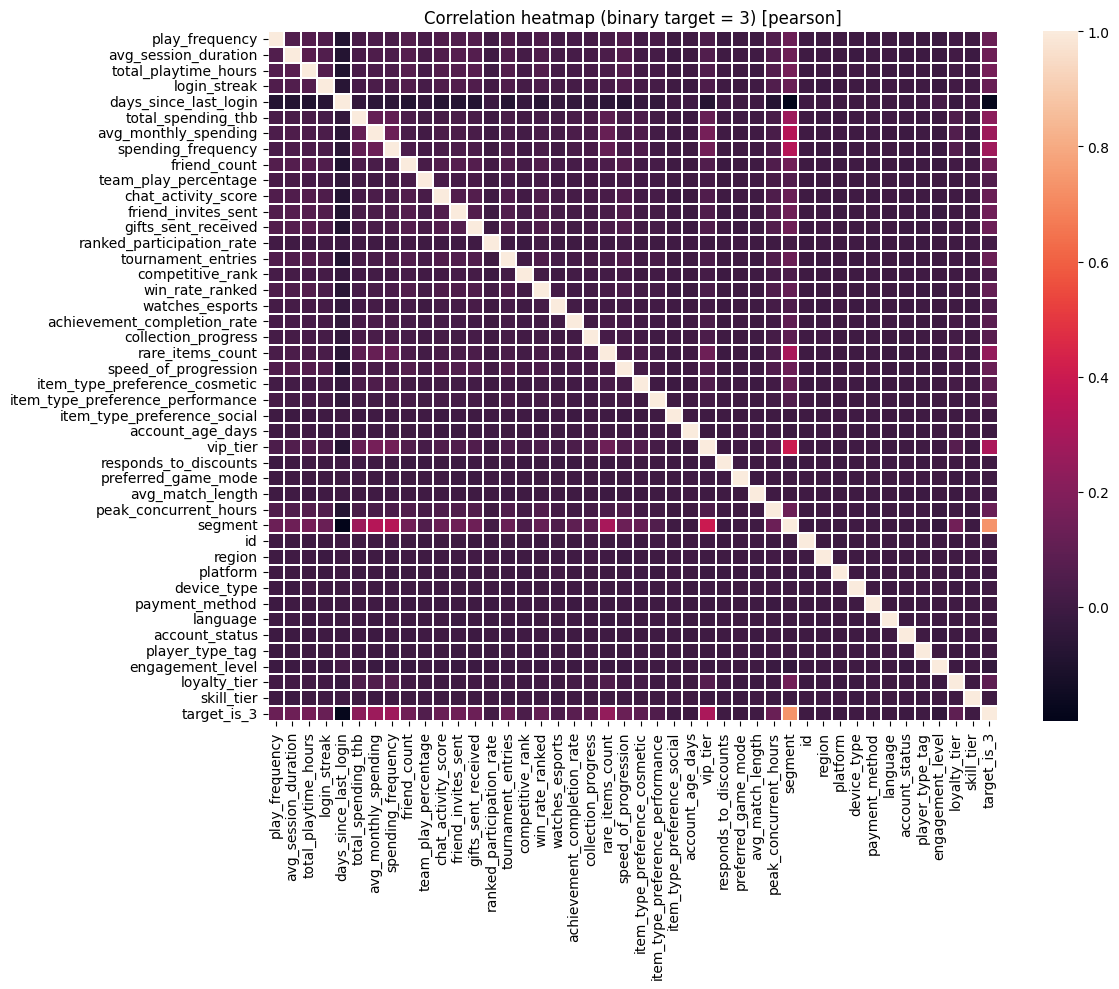


Top features correlated with target == 3:
segment                          0.734071
vip_tier                         0.307498
spending_frequency               0.271987
avg_monthly_spending             0.268899
rare_items_count                 0.242557
total_spending_thb               0.220277
days_since_last_login            0.183479
total_playtime_hours             0.157184
friend_count                     0.145576
friend_invites_sent              0.138237
avg_session_duration             0.136548
gifts_sent_received              0.133485
speed_of_progression             0.128579
play_frequency                   0.128210
peak_concurrent_hours            0.126489
tournament_entries               0.126007
chat_activity_score              0.125478
login_streak                     0.121492
win_rate_ranked                  0.112006
item_type_preference_cosmetic    0.094613
Name: target_is_3, dtype: float64


In [27]:
TARGET_COL = "segment"
CORR_METHOD = "pearson"

numeric_df = df.select_dtypes(include = [np.number]).copy()
numeric_df[TARGET_COL] = df[TARGET_COL]

non_num_cols = [c for c in df.columns if c not in numeric_df.columns and c != TARGET_COL]
for c in non_num_cols:
    try:
        le = LabelEncoder()
        numeric_df[c] = le.fit_transform(df[c].astype(str))
    except Exception:
        # if encoding fails, skip the column
        print(f"Warning: skipping column {c} from encoding")

unique_targets = sorted(df[TARGET_COL].unique())
print("Found unique target values:", unique_targets)

for cls in unique_targets:
    # create a binary target column name
    bin_name = f"target_is_{cls}"
    numeric_df[bin_name] = (df[TARGET_COL] == cls).astype(int)

    # compute correlation matrix over numeric columns
    corr = numeric_df.corr(method = CORR_METHOD)

    # reorder so that binary target is last (nice to view)
    cols = [c for c in corr.columns if c != bin_name] + [bin_name]
    corr = corr.loc[cols, cols]

    # Plot heatmap
    plt.figure(figsize = (12, 10))
    ax = sns.heatmap(
        corr,
        linewidths = 0.3,
    )
    ax.set_title(f"Correlation heatmap (binary target = {cls}) [{CORR_METHOD}]")
    plt.tight_layout()

    plt.show()

    # Also print top features most correlated to the binary target
    corr_with_target = corr[bin_name].drop(bin_name).abs().sort_values(ascending = False)
    print(f"\nTop features correlated with target == {cls}:")
    print(corr_with_target.head(20))

    # remove the binary column to keep df clean for next iteration
    numeric_df.drop(columns = [bin_name], inplace = True)

## Feature Engineering

In [28]:
import numpy as np

def engineer_features(df):
    """
    ฟังก์ชันสำหรับสร้าง Feature ใหม่จากข้อมูลที่มีอยู่
    """
    df_eng = df.copy()

    df_eng['thb_per_hour'] = df_eng['total_spending_thb'] / (df_eng['total_playtime_hours'] + 1)
    df_eng['thb_per_session'] = df_eng['avg_monthly_spending'] / (df_eng['play_frequency'] + 1)

    df_eng['friends_per_hour'] = df_eng['friend_count'] / (df_eng['total_playtime_hours'] + 1)
    df_eng['interaction_score'] = df_eng['chat_activity_score'] * df_eng['friend_invites_sent']

    df_eng['dedication_ratio'] = df_eng['login_streak'] / (df_eng['days_since_last_login'] + 1)

    skewed_cols = ['total_spending_thb', 'total_playtime_hours', 'avg_monthly_spending']
    for col in skewed_cols:
        if col in df_eng.columns:
            df_eng[f'log_{col}'] = np.log1p(df_eng[col])
        
    return df_eng

## Load Data

In [29]:
import pandas as pd
import numpy as np

df = pd.read_csv("Dataset/task2/train.csv")
df = engineer_features(df)
df.drop(columns = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

ordinal_cols  = {
    "engagement_level": {"Low": 0, "Mid": 1, "High": 2, "Veteran" : 3},
    "loyalty_tier": {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4},
    "skill_tier" : {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4}
}
object_cols = df.select_dtypes(include = "object").columns
nominal_cols = [c for c in object_cols if c not in list(ordinal_cols.keys())]

numeric_cols = df.select_dtypes(include = [np.number]).columns.tolist()
numeric_cols.remove("segment")

## Encode Ordinal + Nominal Features

In [30]:
from sklearn.preprocessing import OneHotEncoder

# Encode ordinal features
df_ord = pd.DataFrame()
for col, mapping in ordinal_cols.items():
    df_ord[col] = df[col].map(mapping)

# Encode nominal features
ohe = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

df_nom = pd.DataFrame(
    ohe.fit_transform(df[nominal_cols]),
    columns = ohe.get_feature_names_out(nominal_cols),
    index = df.index
)

In [31]:
from xgboost import XGBClassifier, DMatrix, train as xgb_train

X = pd.concat([df[numeric_cols], df_ord, df_nom], axis = 1)
y = df["segment"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

## Simple XGBoost classifier

In [32]:
model = XGBClassifier(
    objective = "multi:softmax",  # multiclass classification
    num_class = 4,                # classes 0-3
    eval_metric = "mlogloss",
    random_state = 42
)

model.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


## Evaluation

In [33]:
y_pred = model.predict(X_test)
print("Predictions:", y_pred)

Predictions: [3 2 0 ... 0 1 0]


In [34]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average = "macro")
f1_micro = f1_score(y_test, y_pred, average = "micro")
f1_weighted = f1_score(y_test, y_pred, average = "weighted")

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

F1 Macro: 0.7409
F1 Micro: 0.7561
F1 Weighted: 0.7545


## Feature Importance

In [35]:
importance_scores = model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importance_scores
}).sort_values(by = "importance", ascending = False)

feat_importance

,feature,importance
40,loyalty_tier,0.282119
39,engagement_level,0.158972
26,vip_tier,0.054476
35,dedication_ratio,0.023700
4,days_since_last_login,0.019462
...,...,...
63,language_FR,0.003605
50,platform_nan,0.003595
49,platform_PC,0.003590
37,log_total_playtime_hours,0.000000


In [36]:
weak_feature = feat_importance["feature"].tail(30).tolist()

In [37]:
X.drop(columns = weak_feature, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

dmatrix = DMatrix(X_train, label = y_train, missing = np.nan)

In [38]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average = "macro")
f1_micro = f1_score(y_test, y_pred, average = "micro")
f1_weighted = f1_score(y_test, y_pred, average = "weighted")

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

F1 Macro: 0.7392
F1 Micro: 0.7549
F1 Weighted: 0.7532


## Testset

In [39]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective = "multi:softmax",
    num_class = 4,
    eval_metric = "mlogloss",
    max_depth = 8,
    learning_rate = 0.05070708912261347,
    n_estimators = 374,
    subsample = 0.8270714995742705,
    colsample_bytree = 0.8818347452150855,
    gamma = 0.8435745327356242,
    reg_alpha = 1.8212817110030777,
    reg_lambda = 2.0585090154482595,
    random_state = 42 
)

model.fit(X, y)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8818347452150855
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [40]:
inference = pd.read_csv("Dataset/task2/test.csv")
inference = engineer_features(inference)

inference.drop(
    columns = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"],
    inplace = True
)

In [41]:
ordinal_cols_map = {
    "engagement_level": {"Low": 0, "Mid": 1, "High": 2, "Veteran" : 3},
    "loyalty_tier": {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4},
    "skill_tier" : {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4}
}

object_cols = inference.select_dtypes(include = "object").columns
nominal_cols = [c for c in object_cols if c not in ordinal_cols_map.keys()] 

numeric_cols = inference.select_dtypes(include = [np.number]).columns.tolist()

inference_ord = pd.DataFrame()
for col, mapping in ordinal_cols_map.items():
    inference_ord[col] = inference[col].map(mapping)

inference_ord.fillna(-1, inplace = True)
ohe_inference = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

inference_nom = pd.DataFrame(
    ohe.transform(inference[nominal_cols]),
    columns = ohe.get_feature_names_out(nominal_cols),
    index = inference.index
)

In [42]:
X_inference = pd.concat([inference[numeric_cols], inference_ord, inference_nom], axis = 1)
X_inference.drop(columns = weak_feature, inplace = True)

In [43]:
y_pred = model.predict(X_inference)

In [44]:
y_pred

array([2, 0, 0, ..., 1, 0, 3], shape=(25889,), dtype=int32)

# StackEnsemble

In [45]:
import pandas as pd

df = pd.read_csv("Dataset/task2/train.csv")
df = engineer_features(df)

df.drop(columns = ["id", "player_id"], inplace = True)
df.drop(columns = ["random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

## Pipeline

In [46]:
import numpy as np

ordinal_cols  = {
    "engagement_level": ["Low", "Mid", "High", "Veteran"],
    "loyalty_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"],
    "skill_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"]
}

object_cols = df.select_dtypes(include = "object").columns
nominal_cols = [c for c in object_cols if c not in ordinal_cols]

numeric_cols = df.select_dtypes(include = [np.number]).columns.tolist()
numeric_cols.remove("segment")

X = df.drop(columns = ["segment"])
y = df["segment"]

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers = [
        ("ord", 
         OrdinalEncoder(
             categories = [ordinal_cols[c] for c in ordinal_cols],
             handle_unknown = "use_encoded_value",
             unknown_value = -1), 
         list(ordinal_cols.keys())
        ),
        ("nom", OneHotEncoder(handle_unknown = "ignore", sparse_output = False), nominal_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [48]:
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        objective = "multi:softmax",
        num_class = len(y.unique()),
        eval_metric = "mlogloss",
        random_state = 42 
    ))
])

xgb_model.fit(X, y)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ord', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Feature Selection

In [49]:
# Extract Feature Names
X_processed = pd.DataFrame(
    xgb_model.named_steps["preprocess"].transform(X),
    columns = (list(ordinal_cols.keys()) +
               list(xgb_model.named_steps["preprocess"].named_transformers_["nom"].get_feature_names_out(nominal_cols)) + 
               numeric_cols),
    index = X.index
)

# Extract Feature Importance
booster = xgb_model.named_steps["model"].get_booster()
fi = booster.get_score(importance_type = "gain")
fi = pd.Series(fi).sort_values(ascending = False)

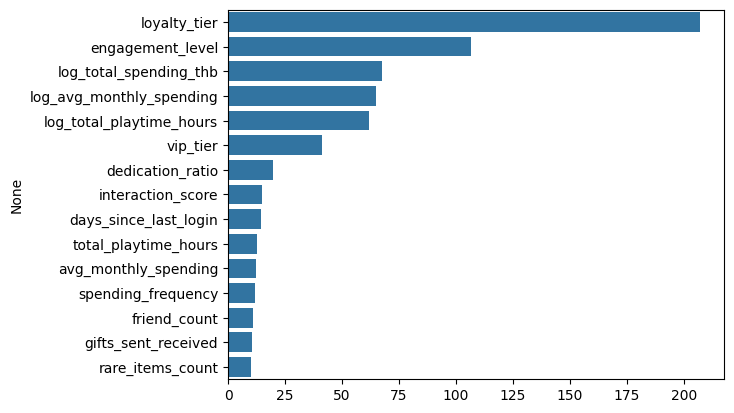

In [50]:
# Visualize

import matplotlib.pyplot as plt
import seaborn as sns

feature_map = {f"f{i}": col for i, col in enumerate(X_processed.columns)}
fi_named = fi.rename(feature_map)

Top15 = fi_named.sort_values(ascending = False).head(15)

sns.barplot(x = Top15.values, y = Top15.index)
plt.show()

In [51]:
cumulative_importance = fi_named.cumsum() / fi_named.sum()
selected_features = cumulative_importance[cumulative_importance <= 0.90].index.tolist()
print(f"Selected {len(selected_features)} features out of {len(fi_named)} total features")

X_selected = X_processed[selected_features].copy()

Selected 42 features out of 75 total features


## Modeling

In [52]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

estimators = [
    ("XGBoost", XGBClassifier(objective = "multi:softprob",
                             num_class = len(y.unique()),
                             eval_metric = "mlogloss", 
                             random_state = 42,
                             n_jobs = 1)),
    
    ("LightGBM", LGBMClassifier(objective = "multiclass", 
                               num_class = len(y.unique()), 
                               metric = "multi_logloss", 
                               random_state = 42,
                               n_jobs = 1)),
    
    ("CatBoost", CatBoostClassifier(loss_function = "MultiClass", 
                                   eval_metric = "MultiClass", 
                                   verbose  = 0, 
                                   random_state = 42,
                                   thread_count = 1))
]

blender = LogisticRegression(
    multi_class = "multinomial",
    max_iter = 2000,
    solver = "saga"   # robust and handles multinomial with L2/L1
)

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",  # use probabilities as meta-features
    cv = 5,                          # internal CV for OOF predictions when building stack
    n_jobs = -1,
    passthrough = False              # don't pass original features to blender
)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(stack, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
print(f"Stacking (XGB+LGBM+Cat -> LR): mean F1 = {scores.mean():.4f}  (+/- {scores.std():.4f})")

Stacking (XGB+LGBM+Cat -> LR): mean F1 = 0.7518  (+/- 0.0024)


## Hyperparameter

In [ ]:
import optuna

n_classes = len(y.unique())

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),     
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log = True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),
        "objective": "multi:softprob",
        "num_class": n_classes,
        "random_state": 42,
        "n_jobs": 1
    }
    
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_xgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 80)
print("Best XGB params:", study_xgb.best_params, "best f1:", 1 - study_xgb.best_value)

In [ ]:
def objective_lgb(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 6, 128),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),
        "random_state": 42,
        "objective": "multiclass",
        "n_jobs": 1
    }
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_lgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_lgb.optimize(objective_lgb, n_trials = 100)
print("Best LGB params:", study_lgb.best_params, "best f1:", 1 - study_lgb.best_value)

In [ ]:
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log = True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_state": 42,
        "verbose": 0
    }
    
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_cat = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_cat.optimize(objective_cat, n_trials = 100)
print("Best Cat params:", study_cat.best_params, "best f1:", 1 - study_cat.best_value)

In [54]:
best_xgb_params = {
    "n_estimators": 421,
    "max_depth": 4,
    "learning_rate": 0.08756665046921236,
    "subsample": 0.725649640017699,
    "colsample_bytree": 0.4353615060588445,
    "gamma": 2.319772497614296e-05,
    "reg_alpha": 0.0007213640801588079,
    "reg_lambda": 3.304345673585518,
    "random_state": 42,
    "objective": "softprob",
    "n_jobs": 1
}

best_lgb_params = {
    "num_leaves": 48,
    "min_child_samples": 49,
    "learning_rate": 0.03371937234804732,
    "n_estimators": 412,
    "subsample": 0.5070674103057174,
    "colsample_bytree": 0.47441192659686016,
    "reg_alpha": 3.0372746107193873e-06,
    "reg_lambda": 2.796310336139618,
    "random_state": 42,
    "objective": "multiclass",
    "n_jobs": 1
}

best_cat_params = {
    "iterations": 2156,
    "learning_rate": 0.07644711988679928,
    "depth": 3,
    "l2_leaf_reg": 9.334751123128543,
    "border_count": 210,
    "random_state": 42,
    "verbose": 0,
}

In [55]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict

estimators = [
    ("lgbm", LGBMClassifier(**best_lgb_params, num_class = n_classes, verbose = -1)),
    ("cat", CatBoostClassifier(**best_cat_params))
]

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

def make_meta_dataset(estimators, X, y, cv):
    meta_cols = []
    fitted = []
    for name, est in estimators:
        probs = cross_val_predict(est, X, y, cv = cv, method = "predict_proba", n_jobs = -1)
        meta_cols.append(probs)
        est_full = clone(est)
        est_full.fit(X, y)
        fitted.append((name, est_full))

    # horizontally stack the prob columns from each estimator -> (n_samples, n_estimators * n_classes)
    X_meta = np.hstack(meta_cols)
    return X_meta, fitted

X_meta, fitted_estimators = make_meta_dataset(estimators, X_selected, y, cv)

In [56]:
def objective_blender_meta(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log = True)
    penalty = trial.suggest_categorical("penalty", ["l2"])

    clf = LogisticRegression(
        C = C,
        penalty = penalty,
        multi_class = "multinomial",
        max_iter = 2000,
        solver = "saga" if penalty == "l1" else "lbfgs"
    )

    scores = cross_val_score(clf, X_meta, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_blender = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_blender.optimize(objective_blender_meta, n_trials = 20) 
print("Best blender params:", study_blender.best_params, "best f1:", 1 - study_blender.best_value)

[I 2025-11-26 00:21:50,186] A new study created in memory with name: no-name-a45c8a85-bab0-498d-8c81-829506070308
[I 2025-11-26 00:21:51,118] Trial 0 finished with value: 0.24630423469617646 and parameters: {'C': 0.017670169402947963, 'penalty': 'l2'}. Best is trial 0 with value: 0.24630423469617646.
[I 2025-11-26 00:21:53,142] Trial 1 finished with value: 0.24603679469502082 and parameters: {'C': 50.61576888752309, 'penalty': 'l2'}. Best is trial 1 with value: 0.24603679469502082.
[I 2025-11-26 00:21:55,246] Trial 2 finished with value: 0.24611717882034556 and parameters: {'C': 2.465832945854912, 'penalty': 'l2'}. Best is trial 1 with value: 0.24603679469502082.
[I 2025-11-26 00:21:57,048] Trial 3 finished with value: 0.24619317988671052 and parameters: {'C': 0.39079671568228835, 'penalty': 'l2'}. Best is trial 1 with value: 0.24603679469502082.
[I 2025-11-26 00:21:57,289] Trial 4 finished with value: 0.24906676154837926 and parameters: {'C': 0.0008632008168602544, 'penalty': 'l2'}. B

Best blender params: {'C': 15.741890047456648, 'penalty': 'l2'} best f1: 0.7540557233269404


In [57]:
study_blender.best_params

{'C': 15.741890047456648, 'penalty': 'l2'}

## Inference

In [58]:
inference = pd.read_csv("Dataset/task2/test.csv")
inference = engineer_features(inference)

drop_cols = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"]
inference.drop(columns = [c for c in drop_cols if c in inference.columns], inplace = True)

# Apply existing preprocessor
X_test_processed = pd.DataFrame(
    xgb_model.named_steps["preprocess"].transform(inference),
    columns = (list(ordinal_cols.keys()) + 
               list(xgb_model.named_steps["preprocess"].named_transformers_["nom"].get_feature_names_out(nominal_cols)) + 
               numeric_cols),
    index = inference.index
)

# Select features chosen in training
X_test_selected = X_test_processed[selected_features].copy()

In [59]:
# --- Base learners ---
xgb_clf = XGBClassifier(
    **best_xgb_params,
    num_class = n_classes,
    verbosity = 0
)

lgbm_clf = LGBMClassifier(
    **best_lgb_params,
    num_class = n_classes,
    verbose = -1
)

cat_clf = CatBoostClassifier(
    **best_cat_params,
)

# --- Blender (LogisticRegression) ---
blender = LogisticRegression(
    multi_class = "multinomial",
    max_iter = 2000,
    solver = "saga",
    **study_blender.best_params
)

# --- Stacking ---
estimators = [("xgb", xgb_clf), ("lgbm", lgbm_clf), ("cat", cat_clf)]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

stack.fit(X_selected, y)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,estimators,"[('xgb', ...), ('lgbm', ...), ...]"
,final_estimator,LogisticRegre...solver='saga')
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,0
,objective,'softprob'
,base_score,None
,booster,None
,callbacks,None


In [60]:
y_test_pred = stack.predict(X_test_selected)
y_test_proba = stack.predict_proba(X_test_selected)

In [61]:
y_test_pred

array([2, 0, 0, ..., 1, 0, 3], shape=(25889,))

In [62]:
submission_df = pd.read_csv("final_submission_task4_swin (2).csv")
target_column = 'task2'

submission_df[target_column] = y_test_pred
submission_df.to_csv("final_submission_task2_Feature_engineering.csv", index=False)
print(submission_df.head())

         id  task1  task2          task3  task4  task5
0  ANS00001    1.0      2     451.118574      0      0
1  ANS00002    0.0      0    1322.827743      2      0
2  ANS00003    1.0      0  164628.202879      3      1
3  ANS00004    0.0      0      75.355058      0      0
4  ANS00005    0.0      0     322.707423      3      0
